In [12]:
%matplotlib inline

import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import seaborn as sns

In [14]:
with gzip.open('human/actions.msg.gz', 'r') as f:
    HUMAN_ACTIONS = pd.read_msgpack(f)

In [15]:
def gather_stats(data, group_keys, value_key):
    new_df = []
    possible_key_values = [ data[key].unique() for key in group_keys ]
    value_columns = [value_key + '_count', value_key + '_prob']
    for possible_assignment in itertools.product(*possible_key_values):
        selection = data
        for key, assignment in zip(group_keys, possible_assignment):
            selection = selection[selection[key] == assignment]
        if len(selection) == 0:
            continue
        counts = selection[value_key].value_counts()
        for key, count in counts.iteritems():
            if count == 0:
                continue
            new_df.append(dict(zip(
                group_keys + [value_key] + value_columns,
                possible_assignment + (key, count, float(count) / len(selection))
            )))
    
    return pd.DataFrame(new_df, columns=group_keys + [value_key] + value_columns).set_index(group_keys)

In [30]:
def grouped_barplot(plot_title, series_titles, group_titles, basis, *serieses):
    plt.figure(figsize=(16,8))
    # set width of bar
    COLORS = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3']
    barWidth = 1.0/(1 + len(serieses))

    # set height of bar
    bars1 = serieses[0]

    # Set position of bar on X axis
    positions = [ np.arange(len(bars1)) ]
    for _ in range(len(serieses) - 1):
        positions.append([x + barWidth for x in positions[-1] ])

    for i, (title, pos, series) in enumerate(zip(series_titles, positions, serieses)):
        plt.bar(pos, series, color=COLORS[i], width=barWidth, edgecolor='white', label=title)

    if basis is not None:
        plt.axhline(basis, color="gray")
        
    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth*(len(serieses) / 2.0 - 0.5) for r in range(len(bars1))], group_titles)

    # Create legend & Show graphic
    plt.title(plot_title)
    plt.legend()
    plt.show()

# Do people propose themselves?

To the surprise of no one - yes.

In [16]:
filtered_data = HUMAN_ACTIONS[(HUMAN_ACTIONS.type == 'propose') & (HUMAN_ACTIONS.num_players == 5)]
gather_stats(filtered_data, ['num_players', 'role', 'round'], 'propose_has_self')

propose_has_self  propose_has_self_count  \
num_players role     round                                             
5           minion   0                  True                     604   
                     0                 False                      81   
                     1                  True                     610   
                     1                 False                      67   
                     2                  True                     497   
                     2                 False                     147   
                     3                  True                     491   
                     3                 False                      53   
                     4                  True                     240   
                     4                 False                      42   
            servant  0                  True                    3859   
                     0                 False                     636   
                     1                  True                    4028   
                     1                 False                     126   
                     2                  True                    3272   
                     2                 False                     514   
                     3                  True                    3125   
                     3                 False                      39   
                     4                  True                    1577   
                     4                 False                      14   
            assassin 0                  True                    2927   
                     0                 False                     403   
                     1                  True                    2842   
                     1                 False                     158   
                     2                  True                    2083   
                     2                 False                     509   
                     3                  True                    1905   
                     3                 False                     222   
                     4                  True                     864   
                     4                 False                     146   
...                                      ...                     ...   
            percival 0                  True                    1864   
                     0                 False                     356   
                     1                  True                    2052   
                     1                 False                      44   
                     2                  True                    1449   
                     2                 False                     276   
                     3                  True                    1449   
                     3                 False                      18   
                     4                  True                     705   
                     4                 False                       4   
            oberon   0                  True                     381   
                     0                 False                      41   
                     1                  True                     318   
                     1                 False                      20   
                     2                  True                     192   
                     2                 False                      81   
                     3                  True                     192   
                     3                 False                      44   
                     4                  True                      95   
                     4                 False                      24   
            mordred  0                  True                     164   
                     0                 False                      21   
                     1                  True                     148

# Do people vote up missions that don't have them?

To the surprise of no one - no.

In [17]:
filtered_data = HUMAN_ACTIONS[(HUMAN_ACTIONS.type == 'vote') & (HUMAN_ACTIONS.num_players == 5)]
gather_stats(filtered_data, ['num_players', 'role', 'round', 'propose_has_self'], 'move')

move  move_count  move_prob
num_players role    round propose_has_self                                
5           minion  0     True              Approve        1077   0.797187
                          True               Reject         274   0.202813
                          False              Reject        1254   0.592348
                          False             Approve         863   0.407652
                    1     True              Approve        1245   0.701804
                          True               Reject         529   0.298196
                          False              Reject        1117   0.661338
                          False             Approve         572   0.338662
                    2     True              Approve         758   0.793717
                          True               Reject         197   0.206283
                          False              Reject        1552   0.646397
                          False             Approve         849   0.353603
                    3     True              Approve         865   0.752174
                          True               Reject         285   0.247826
                          False              Reject        1237   0.728504
                          False             Approve         461   0.271496
                    4     True              Approve         416   0.722222
                          True               Reject         160   0.277778
                          False              Reject         708   0.714430
                          False             Approve         283   0.285570
            servant 0     True              Approve        8132   0.869547
                          True               Reject        1220   0.130453
                          False              Reject        8959   0.691014
                          False             Approve        4006   0.308986
                    1     True              Approve        9191   0.664810
                          True               Reject        4634   0.335190
                          False              Reject        5668   0.835988
                          False             Approve        1112   0.164012
                    2     True              Approve        7298   0.814327
                          True               Reject        1664   0.185673
...                                             ...         ...        ...
            oberon  2     False              Reject         753   0.666962
                          False             Approve         376   0.333038
                    3     True              Approve         287   0.799443
                          True               Reject          72   0.200557
                          False              Reject         575   0.691937
                          False             Approve         256   0.308063
                    4     True              Approve         140   0.823529
                          True               Reject          30   0.176471
                          False              Reject         313   0.697105
                          False             Approve         136   0.302895
            mordred 0     True              Approve         296   0.843305
                          True               Reject          55   0.156695
                          False              Reject         369   0.668478
                          False             Approve         183   0.331522
                    1     True              Approve         326   0.744292
                          True               Reject         112   0.255708
                          False              Reject         265   0.704787
                          False             Approve         111   0.295213
                    2     True              Approve         205   0.807087
                          True               Reject          49   0.192913
                          False              Reject         371   0.6625

# Do bad people fail missions?

In [18]:
filtered_data = HUMAN_ACTIONS[(HUMAN_ACTIONS.type == 'mission') & (HUMAN_ACTIONS.num_players == 5) & (HUMAN_ACTIONS.is_evil)]
gather_stats(filtered_data, ['num_players', 'role', 'round'], 'move')

move  move_count  move_prob
num_players role     round                                
5           minion   0      Succeed         539   0.722520
                     0         Fail         207   0.277480
                     1         Fail         597   0.668533
                     1      Succeed         296   0.331467
                     2         Fail         255   0.557987
                     2      Succeed         202   0.442013
                     3         Fail         387   0.841304
                     3      Succeed          73   0.158696
                     4         Fail         196   0.965517
                     4      Succeed           7   0.034483
            assassin 0      Succeed        1929   0.770060
                     0         Fail         576   0.229940
                     1         Fail        2352   0.721915
                     1      Succeed         906   0.278085
                     2         Fail         850   0.537295
                     2      Succeed         732   0.462705
                     3         Fail        1329   0.861309
                     3      Succeed         214   0.138691
                     4         Fail         598   0.959872
                     4      Succeed          25   0.040128
            morgana  0      Succeed        1217   0.851049
                     0         Fail         213   0.148951
                     1         Fail         944   0.525028
                     1      Succeed         854   0.474972
                     2      Succeed         502   0.557159
                     2         Fail         399   0.442841
                     3         Fail         637   0.750294
                     3      Succeed         212   0.249706
                     4         Fail         298   0.955128
                     4      Succeed          14   0.044872
            oberon   0         Fail         165   0.611111
                     0      Succeed         105   0.388889
                     1         Fail         236   0.819444
                     1      Succeed          52   0.180556
                     2         Fail          55   0.733333
                     2      Succeed          20   0.266667
                     3         Fail          82   0.942529
                     3      Succeed           5   0.057471
                     4         Fail          34   1.000000
            mordred  0      Succeed         132   0.825000
                     0         Fail          28   0.175000
                     1         Fail         134   0.587719
                     1      Succeed          94   0.412281
                     2         Fail          64   0.507937
                     2      Succeed          62   0.492063
                     3         Fail         123   0.897810
                     3      Succeed          14   0.102190
                     4         Fail          48   0.979592
                     4      Succeed           1   0.020408

[[0.2774798927613941, 0.6685330347144457, 0.5579868708971554, 0.841304347826087, 0.9655172413793104], [0.22994011976047904, 0.7219152854511971, 0.5372945638432364, 0.8613091380427739, 0.9598715890850722], [0.175, 0.5877192982456141, 0.5079365079365079, 0.8978102189781022, 0.9795918367346939], [0.14895104895104896, 0.525027808676307, 0.4428412874583796, 0.7502944640753828, 0.9551282051282052], [0.6111111111111112, 0.8194444444444444, 0.7333333333333333, 0.9425287356321839, 1.0]]


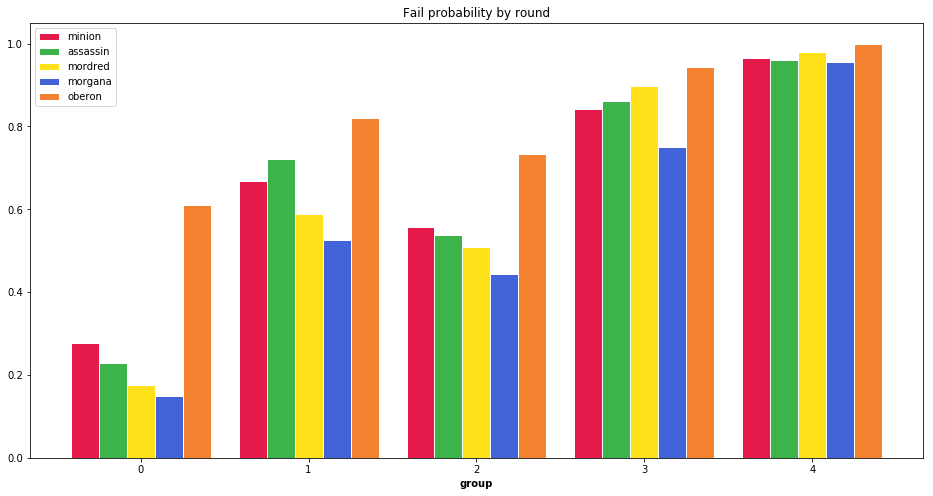

In [44]:
d = gather_stats(filtered_data, ['num_players', 'role', 'round'], 'move')

d.reset_index(level=['role', 'round'], inplace=True)
d.reset_index(drop=True, inplace=True)
d


plot_title = "Fail probability by round"
trembles = ["minion", "assassin", "mordred", "morgana", "oberon"]
bots = [0, 1, 2, 3, 4]
serieses = [ [ d[(d['round'] == bot) & (d.move == 'Fail') & (d.role == p)].move_prob.iloc[0] for bot in bots] for p in trembles ]
print serieses
grouped_barplot(plot_title, trembles, bots, None, *serieses)

# Gimme those decision treees

In [65]:
from StringIO import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
def visualize_decision_tree(dtree, feature_names):
    dot_data = StringIO()
    export_graphviz(dtree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True, feature_names=feature_names)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

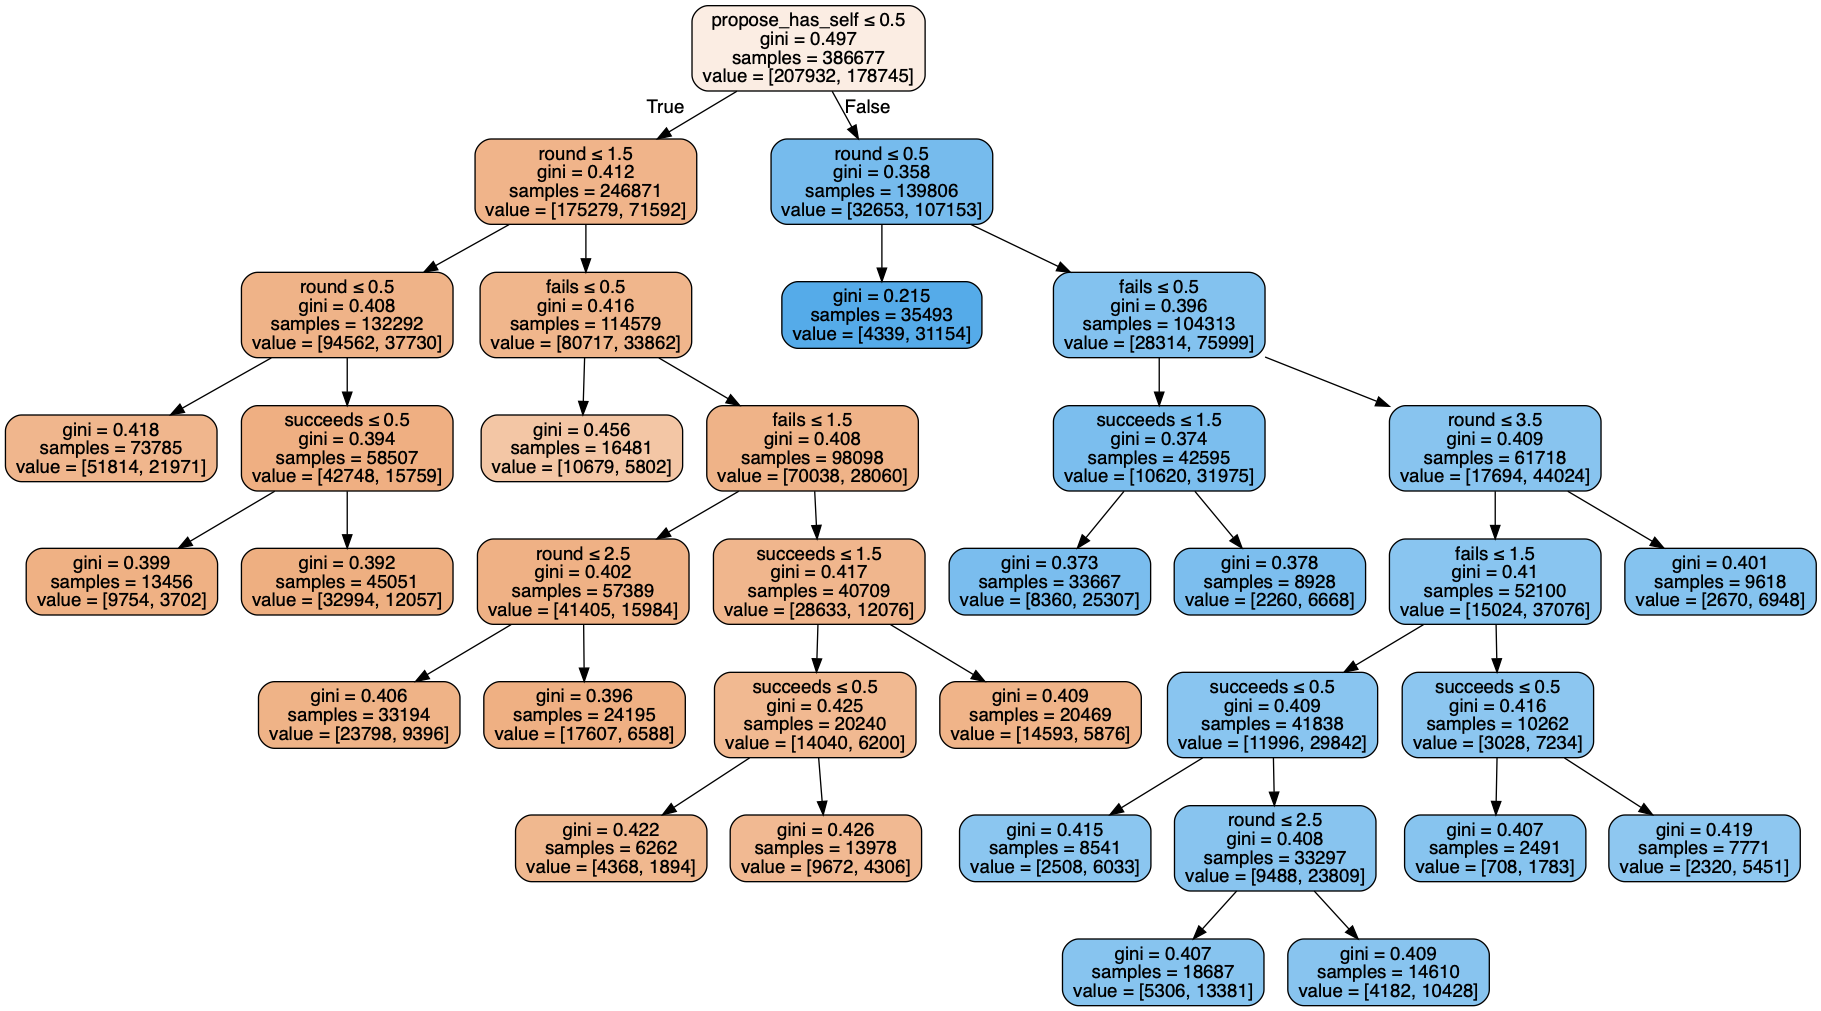

In [77]:
VOTE_ONLY = HUMAN_ACTIONS[(HUMAN_ACTIONS.type == 'vote') & (HUMAN_ACTIONS.is_evil)]

features = ['is_evil', 'propose_has_self', 'round', 'succeeds', 'fails']
X = VOTE_ONLY[features]
y = VOTE_ONLY.move == 'Approve'

dt = DecisionTreeClassifier(min_samples_split=100, random_state=99)
dt.fit(X, y)
visualize_decision_tree(dt, features)

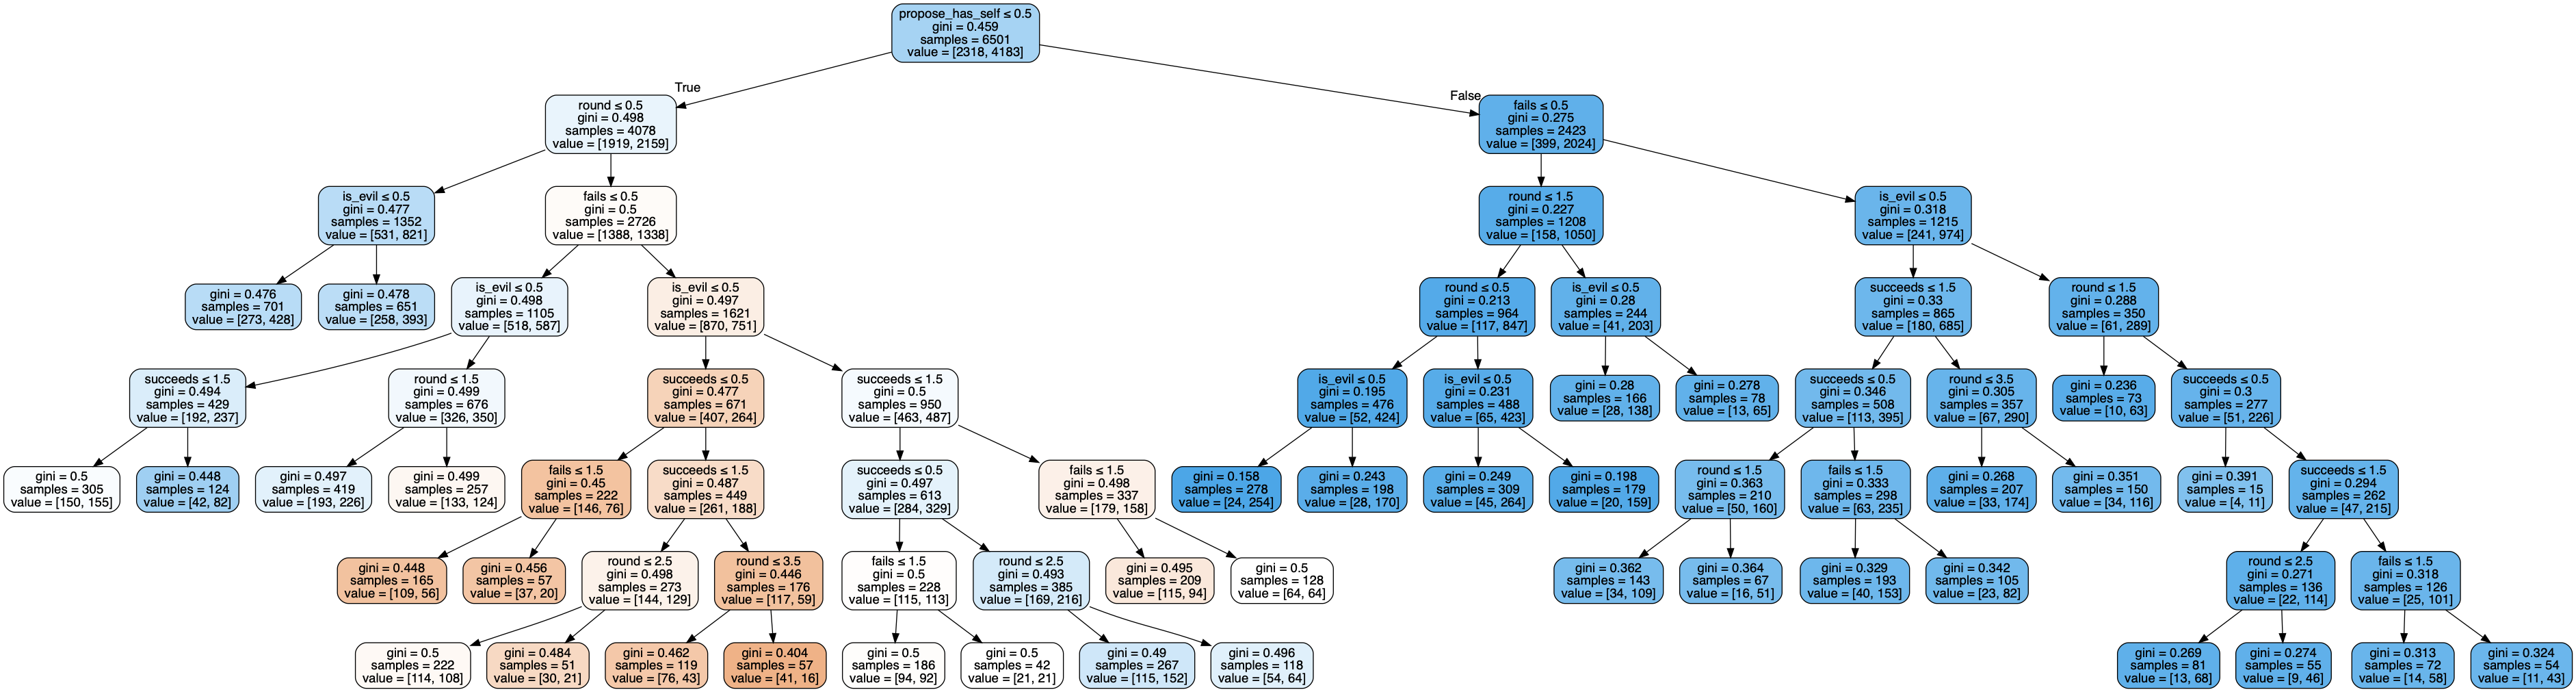

In [82]:
BOTTOM1000_PLAYERS = HUMAN_ACTIONS.player.value_counts()[-1000:].reset_index()['index']
VOTE_ONLY = HUMAN_ACTIONS[(HUMAN_ACTIONS.type == 'vote') & (HUMAN_ACTIONS.player.isin(BOTTOM1000_PLAYERS))]

features = ['is_evil', 'propose_has_self', 'round', 'succeeds', 'fails']
X = VOTE_ONLY[features]
y = VOTE_ONLY.move == 'Approve'

dt = DecisionTreeClassifier(min_samples_split=100, random_state=99)
dt.fit(X, y)
visualize_decision_tree(dt, features)

In [132]:
GAMES_WITH_PLAYERS = HUMAN_ACTIONS.groupby(['game', 'player']).size().reset_index()[['game', 'player']]
GAMES_WITH_PLAYERS.player.value_counts().quantile(np.arange(0, 1.01, 0.05))

0.00       1.00
0.05       1.00
0.10       1.00
0.15       1.00
0.20       1.00
0.25       2.00
0.30       2.00
0.35       3.00
0.40       3.00
0.45       4.00
0.50       4.00
0.55       5.00
0.60       6.00
0.65       8.00
0.70       9.00
0.75      12.00
0.80      15.00
0.85      21.00
0.90      31.00
0.95      55.55
1.00    1785.00
Name: player, dtype: float64